In [3]:
# importing all necessary dependencies
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

## Electric Vehicle (EV) Scraping

In [4]:
# extracting EV data
url = 'https://en.wikipedia.org/wiki/Electric_car_use_by_country'
tables = pd.read_html(url)
df = tables[1]

# cleaning unnecessary columns and rows
df = df.drop(columns=[1, 2])
df = df.iloc[2:12]

# renaming columns
df.columns = ['country', '2018_sales', '2017_sales', 'population', 
              'EVperK', 'EVpercent']
df

,country,2018_sales,2017_sales,population,EVperK,EVpercent
2,China[iii][iv],"1,016,002[44]","579,000[45]",1394.2,1.6,0.94% (2018)[46]
3,USA[iii],"361,307[47]","199,818[47]",328.5,3.4,0.45% (2018)
4,Norway[v][iv],"86,290[16]","71,737[50]",5.3,55.9,10.7% (2018)[51]
5,Japan[iii][vi][iv],"52,013[52]","54,100[43]",126.3,2.0,NaN
6,UK,"59,911[iii][54]","49,182[iii][54]",66.0,3.2,0.2% (2016)[55]
7,France,"53,745[58]","42,799[58]",67.0,3.1,0.2% (2016)[55]
8,Germany[iii],"67,504[60]","54,492[59]",82.9,2.4,0.1% (2016)[55]
9,Netherlands[iv],"29,187[61]","11,085[61]",17.3,8.4,1.7% (2018)
10,Canada[iii],"33,879[vii][62]","18,746[62]",37.3,2.2[vii],NaN
11,Sweden[iv],"29,909[63]","19,793[63]",10.2,7.8,0.6% (2016)[55]


In [5]:
# cleaning the values by deleting unwanted parts
country = df["country"].str.split("[", n = 1, expand = True)
sales18 = df["2018_sales"].str.split("[", n = 1, expand = True)
sales17 = df["2017_sales"].str.split("[", n = 1, expand = True)
evpercent = df["EVpercent"].str.split("%", n = 1, expand = True)
evperk = df["EVperK"].str.split("[", n = 1, expand = True)
df["country"] = country[0]
df["2018_sales"] = sales18[0]
df["2017_sales"] = sales17[0]
df["EVperK"] = evperk[0]
df["EVpercent"] = evpercent[0]
df

,country,2018_sales,2017_sales,population,EVperK,EVpercent
2,China,"1,016,002","579,000",1394.2,1.6,0.94
3,USA,"361,307","199,818",328.5,3.4,0.45
4,Norway,"86,290","71,737",5.3,55.9,10.7
5,Japan,"52,013","54,100",126.3,2.0,NaN
6,UK,"59,911","49,182",66.0,3.2,0.2
7,France,"53,745","42,799",67.0,3.1,0.2
8,Germany,"67,504","54,492",82.9,2.4,0.1
9,Netherlands,"29,187","11,085",17.3,8.4,1.7
10,Canada,"33,879","18,746",37.3,2.2,NaN
11,Sweden,"29,909","19,793",10.2,7.8,0.6


## Bic Mac (BM) Scraping

In [7]:
# Use pandas to read the HTML and set it to a Dataframe
url2 = "https://www.worldatlas.com/articles/the-world-s-most-expensive-countries-measured-by-the-big-mac-index.html"
df2 = pd.read_html(url2, flavor="bs4")
data = df2[0]
data.head()

,Rank,﻿Country,Big Mac Price in US Dollars
0,1,Switzerland,6.8
1,2,Norway,6.2
2,3,Sweden,6.1
3,4,Finland,5.6
4,5,United States,5.3


In [8]:
# Fix the columns so they are not so long
data.columns = ["Rank", "country", "BM_Dollars"]
df['country'].replace({'USA': 'United States', 'UK': 'Britain'}, inplace=True)

# Merging BM and EV tables
final_df = pd.merge(df, data, on='country')
final_df

,country,2018_sales,2017_sales,population,EVperK,EVpercent,Rank,BM_Dollars
0,China,"1,016,002","579,000",1394.2,1.6,0.94,43,3.2
1,United States,"361,307","199,818",328.5,3.4,0.45,5,5.3
2,Norway,"86,290","71,737",5.3,55.9,10.7,2,6.2
3,Japan,"52,013","54,100",126.3,2.0,NaN,36,3.4
4,Britain,"59,911","49,182",66.0,3.2,0.2,21,4.4
5,France,"53,745","42,799",67.0,3.1,0.2,7,5.1
6,Germany,"67,504","54,492",82.9,2.4,0.1,17,4.8
7,Netherlands,"29,187","11,085",17.3,8.4,1.7,19,4.5
8,Canada,"33,879","18,746",37.3,2.2,NaN,6,5.3
9,Sweden,"29,909","19,793",10.2,7.8,0.6,3,6.1


In [10]:
# Connecting to database
rds_connection_string = "postgres:<password>@localhost:5432/BMvsEV"
engine = create_engine(f'postgresql://{rds_connection_string}')

# Loading tables into database
final_df.to_sql(name='bigmacev', con=engine, if_exists='append', index=False)

In [32]:
engine.table_names()

['bigmacev']

In [12]:
# checking if the values are loaded properly
pd.read_sql_query("select * from bigmacev", con=engine).head()

,country,2018_sales,2017_sales,population,EVperK,EVpercent,Rank,BM_Dollars
0,China,"1,016,002","579,000",1394.2,1.6,0.94,43,3.2
1,United States,"361,307","199,818",328.5,3.4,0.45,5,5.3
2,Norway,"86,290","71,737",5.3,55.9,10.7,2,6.2
3,Japan,"52,013","54,100",126.3,2.0,None,36,3.4
4,Britain,"59,911","49,182",66.0,3.2,0.2,21,4.4


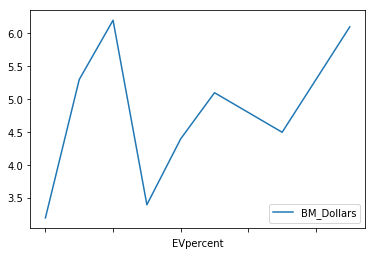

In [13]:
# making plots
final_df.plot(x='EVpercent', y='BM_Dollars')
plt.show()

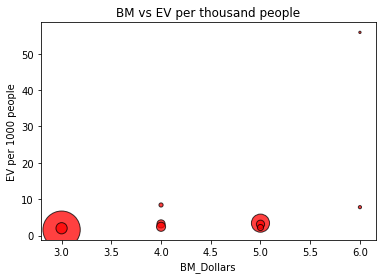

In [30]:
plt.scatter(final_df.BM_Dollars.astype(int), final_df.EVperK.astype(float), marker="o", facecolors="red", edgecolors="black",
            s=final_df.population.astype(float), alpha=0.75)
plt.xlabel("BM_Dollars")
plt.ylabel("EV per 1000 people")
plt.title("BM vs EV per thousand people")
plt.show()

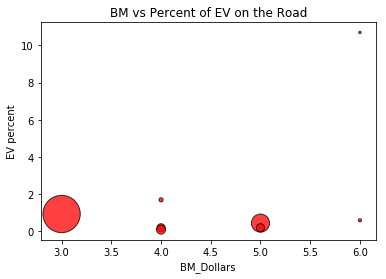

In [31]:
plt.scatter(final_df.BM_Dollars.astype(int), final_df.EVpercent.astype(float), marker="o", facecolors="red", edgecolors="black",
            s=final_df.population.astype(float), alpha=0.75)
plt.xlabel("BM_Dollars")
plt.ylabel("EV percent")
plt.title("BM vs Percent of EV on the Road")
plt.show()